In [1]:
"""
Example script that scrapes data from the IEM ASOS download service
"""
from __future__ import print_function
import json
import time
from datetime import datetime, timedelta
#import datetime
import pandas as pd

# Python 2 and 3: alternative 4
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen

# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"


def download_data(uri):
    """Fetch the data from the IEM
    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.
    Args:
      uri (string): URL to fetch
    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


def get_stations_from_filelist():
    """Build a listing of stations from a simple file listing the stations.
    The file should simply have one station per line.
    """
    stations = []
    for line in open(filename):
        stations.append(line.strip())
    return stations


def get_stations_from_networks():
    """Build a station list by using a bunch of IEM networks."""
    stations = ["ATL"]
    states = "GA"
    # IEM quirk to have Iowa AWOS sites in its own labeled network
    networks = ["AWOS"]
    for state in states.split():
        networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/" "geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations.append(site["properties"]["sid"])
    return stations

def get_weather_data(start_date, end_date):#this function not called here just for reference 
    """Our main method"""
    # timestamps in UTC to request data for
    startts = start_date
    endts = end_date

    service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&"

    service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
    service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

    # Two examples of how to specify a list of stations
    #stations = get_stations_from_networks()
    #stations = get_stations_from_filelist("stations.txt")
    
    
    #station name and parameter can be found from following the website
    #https://mesonet.agron.iastate.edu/request/download.phtml
    stations = ["VCBI","SKSM","ATL"]  
    data_types = ["tmpf","alti"] #alti: pressure , tmpf: temperature in F , alti: altitude in inches
    for station in stations:
        
        for station in stations:
            for data_type in data_types:
                service = SERVICE + "data=" + data_type + "&tz=Etc/UTC&format=onlytdf&=yes&"
                service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
                service += endts.strftime("year2=%Y&month2=%m&day2=%d&")
                uri = "%s&station=%s" % (service, station)
                print("Downloading: %s" % (station,))
                data = download_data(uri)
                outfn = "%s_%s.csv" % (
                    station,
                    data_type
                )
                out = open(outfn, "w")
                out.write(data)
                out.close()
                df = pd.read_csv(outfn, sep='\t')
                print(df)
def main():
    
    """Our main method"""
    # timestamps in UTC to request data for
    startts = datetime.utcnow().date() - timedelta(days=1095)#datetime.datetime(2020, 6, 15)
    endts   = datetime.utcnow().date()
    
    
    # Two examples of how to specify a list of stations
    #stations = get_stations_from_networks()
    # stations = get_stations_from_filelist("mystations.txt")
    
    stations = ["DNAA"]
    dfs = []   
    data_types = ["alti", "tmpf"]
    for station in stations:
        
        for data_type in data_types:
     
            service = SERVICE + "data="+data_type+"&tz=Etc/UTC&format=onlytdf&=yes&"

            service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
            service += endts.strftime("year2=%Y&month2=%m&day2=%d&")
    

            
            uri = "%s&station=%s" % (service, station)
            print("Downloading: %s" % (station,))
            data = download_data(uri)
            outfn = "%s_%s_%s.txt" % (
                station,
                startts.strftime("%Y%m%d%H%M"),
                endts.strftime("%Y%m%d%H%M"),
            )
            out = open(outfn, "w")
            out.write(data)
            out.close()
            
            df = pd.read_csv(outfn, sep= '\t' )


            out.close()
            dfs.append(df)




            df.head()
            print(df)
            


    
    final_dataframe = pd.merge(dfs[0], dfs[1])
    print(final_dataframe)
    
    final_dataframe.to_csv("abuja_alti_temp.csv",index = False)




if __name__ == "__main__":
    main()

Downloading: DNAA
      station             valid   alti
0        DNAA  2021-08-25 00:00  29.88
1        DNAA  2021-08-25 01:00  29.88
2        DNAA  2021-08-25 02:00  29.85
3        DNAA  2021-08-25 03:00  29.85
4        DNAA  2021-08-25 04:00  29.85
...       ...               ...    ...
21463    DNAA  2024-08-23 19:00  29.91
21464    DNAA  2024-08-23 20:00  29.94
21465    DNAA  2024-08-23 21:00  29.97
21466    DNAA  2024-08-23 22:00  30.00
21467    DNAA  2024-08-23 23:00  30.00

[21468 rows x 3 columns]
Downloading: DNAA
      station             valid   tmpf
0        DNAA  2021-08-25 00:00  77.00
1        DNAA  2021-08-25 01:00  77.00
2        DNAA  2021-08-25 02:00  75.20
3        DNAA  2021-08-25 03:00  75.20
4        DNAA  2021-08-25 04:00  75.20
...       ...               ...    ...
21463    DNAA  2024-08-23 19:00  73.40
21464    DNAA  2024-08-23 20:00  73.40
21465    DNAA  2024-08-23 21:00  75.20
21466    DNAA  2024-08-23 22:00  75.20
21467    DNAA  2024-08-23 23:00  75.20

[

/usr/bin/python3
2021-08-25 00:00:00+00:00 2024-08-23 23:00:00+00:00


/tmp/ipykernel_2339916/2508308008.py:178: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  merged_df_1day   = merged_df1.loc[yesterday:now].copy()
/tmp/ipykernel_2339916/2508308008.py:180: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  merged_df_31days =merged_df1.loc[lastmonth:now].copy()


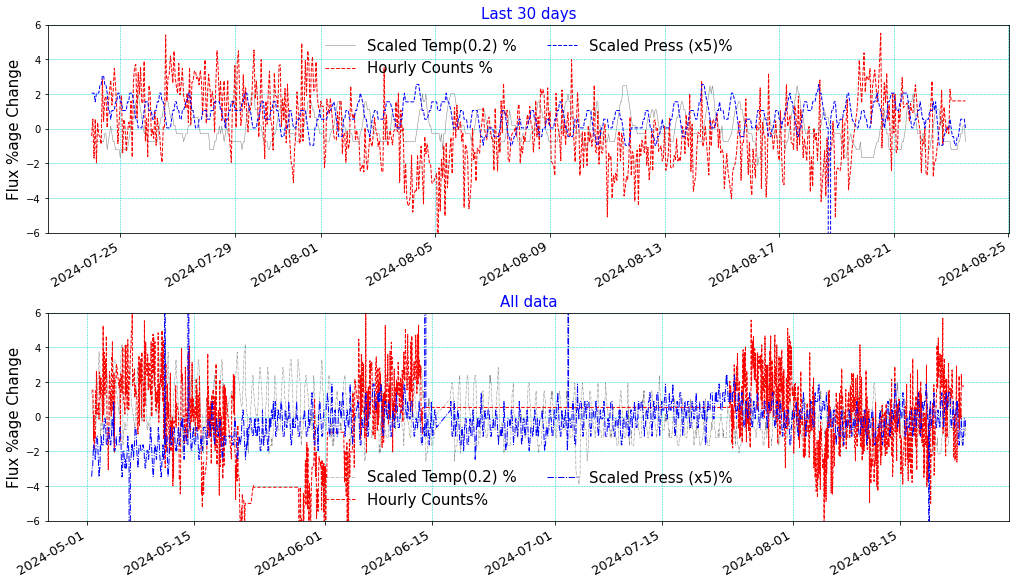

In [2]:
#importing libraries and packages
import sys,os,time
print(sys.executable)
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers
from pandas.tseries.frequencies import to_offset# needed to set the time offset to match to the muons DF
import seaborn as sns
from numpy import argmax
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder

from datetime import datetime, timedelta
def merge_tables(df1, dfpt):
    t1start=pd.Timestamp(df1.index[0])
    t1end=pd.Timestamp(df1.index[-1])
    print(t1start,t1end)
    dfpt1 = dfpt.loc[t1start:t1end].copy()
    merged_tab=pd.merge(df1,dfpt1, how='inner', left_index=True, right_index=True)
    return merged_tab

def calc_percent_change(merged_df):
    
    
    merged_df["counts_pct"] = ((merged_df['counts'] - merged_df['counts'].mean())/ 
                      merged_df['counts'].mean()*100)
    merged_df["counts_m_avg"] = merged_df.rolling('6H').counts_pct.mean()
    merged_df["press_pct"] = 5*((merged_df['alti'] - merged_df['alti'].mean())/ 
                      merged_df['alti'].mean()*100)
    merged_df["temp_pct"] = ((merged_df['tmpf'] - merged_df['tmpf'].mean())/ 
                      merged_df['tmpf'].mean()*100)
    merged_df['temp_scaled'] = 0.2*merged_df['temp_pct']
    #merged_df1["delta_cts"]  = (merged_df1["counts"]-merged_df1["counts"].mean())/merged_df1["counts"]
    #merged_df1["delta_pres"] = (merged_df1["alti"]-merged_df1["alti"].mean())/merged_df1["alti"]
    merged_df["delta_cts"]  = np.log((merged_df["counts"])/merged_df["counts"].mean())
    merged_df["delta_pres"] = (merged_df["alti"]-merged_df["alti"].mean())
    #print(merged_df["alti"].mean(),merged_df["alti"].std(), merged_df['counts_pct'].max(), merged_df["counts"].mean(),merged_df["counts_pct"].std())
    return merged_df


# Specify the directory where your log files are stored
log_directory = '/home/cosmic/Abuja'

# Get a list of all files in the directory
all_files = os.listdir(log_directory)

# Filter only files with a specific extension (e.g., '.log')
log_files = [file for file in all_files if file.endswith('.log')]

#print(log_files)

# Initialize an empty DataFrame
merged_df1 = pd.DataFrame()

# Iterate through each log file
for log_file in log_files:
    # Create the full path for the log file
    log_file_path = os.path.join(log_directory, log_file)
  
    # Read the log file into a DataFrame
    with open(log_file_path, 'r') as file:
        log_content = file.read()
        df = pd.read_csv(log_file_path, sep='\t',names=["counts"])
        
        # Merge the current DataFrame with the overall DataFrame
        merged_df1 = pd.concat([merged_df1, df], axis=0, ignore_index=True)

merged_df1= merged_df1['counts'].str.split(" ", n = 4,expand = True)
#print(merged_df)
      
# Convert the 'datetime' column to datetime format
merged_df1[4] = pd.to_datetime(merged_df1[4], errors='coerce').dt.floor('min')

# Check if there are missing values in the datetime column

# Create a continuous date-time range
date_range = pd.date_range(start=merged_df1[4].min(), end=merged_df1[4].max(), freq='1T')

complete_df = pd.DataFrame(date_range, columns=['date'])

# Step 3: Merge the complete range with the original dataframe
merged_df1 = pd.merge(complete_df, merged_df1, left_on=complete_df.columns[0], right_on=merged_df1.columns[4], how='left')


# Step 4: Identify hours with any missing data and set the entire hour's data to NaN
merged_df1['hour'] = merged_df1[4].dt.floor('H')
missing_hours = merged_df1[merged_df1[3].isna()]['date'].dt.floor('H').unique()

# Create a boolean mask to identify rows where 'hour' is in missing_hours
mask = merged_df1['hour'].isin(missing_hours)

# Set all columns except the 5th column to NaN where the mask is True
merged_df1.loc[mask, merged_df1.columns != merged_df1.columns[0]] = np.nan

# Drop the 'hour' column as it was only needed for processing
merged_df1= merged_df1.drop(columns=['hour'])
merged_df1 = merged_df1.iloc[:, :-1]


# The merged_df now contains the complete datetime range with NaNs filled for missing data
#print(merged_df1)
named_df = pd.DataFrame(merged_df1.values, columns = ["date","junk", "counts","junk1","junk2"])
named_df['counts'] = named_df['counts'].replace(',', '', regex=True)
named_df["date"]= pd.to_datetime(named_df['date'], format="%a %b %d %H:%M:%S %Y")
named_df['date'] = named_df['date'].dt.tz_localize('America/New_York',nonexistent='shift_forward')#setting current time zone
named_df['date'] = named_df['date'].dt.tz_convert('UTC')#convert time zone to UTC
named_df   = named_df.set_index('date')
#pd.to_datetime(named_df.index)
named_df["counts"] = named_df["counts"].apply(pd.to_numeric)
named_df.drop(named_df.columns[[0,2,3]],axis=1, inplace=True)

df_hourly = named_df.resample('H').sum()

df_hourly.drop(df_hourly.head(1).index,inplace=True)
df_hourly.drop(df_hourly.tail(1).index,inplace=True)


# Function to replace consecutive zeros with the average of nearest non-zero values
def replace_zeros_with_avg(df, col_name):
    zero_mask = (df[col_name] == 0)
    zero_groups = zero_mask.ne(zero_mask.shift()).cumsum()  # Create groups of consecutive zeros
    for group, values in df.loc[zero_mask, col_name].groupby(zero_groups):
        if len(values) > 0:
            before = df.loc[values.index.min() - pd.Timedelta(hours=1), col_name] if values.index.min() > df.index.min() else np.nan
            after = df.loc[values.index.max() + pd.Timedelta(hours=1), col_name] if values.index.max() < df.index.max() else np.nan
            avg = np.nanmean([before, after])
            df.loc[values.index, col_name] = avg

# Apply the function to 'counts' column
replace_zeros_with_avg(df_hourly, 'counts')




fPT1    ='abuja_alti_temp.csv'
df1_PT  = pd.read_csv(fPT1)
df1_PT.drop(df1_PT[df1_PT['alti'] == 'M'].index, inplace = True)
df1_PT.drop(df1_PT[df1_PT['tmpf'] == 'M'].index, inplace = True)
df1_PT.dropna(inplace=True)
df1_PT['valid'] = pd.to_datetime(df1_PT['valid'],utc=True)
df1_PT = df1_PT.set_index('valid')
df1_PT = df1_PT.drop(columns=["station"])
#print(df1_PT)
loffset = '0min'
df1_PT.index = df1_PT.index + to_offset(loffset)
#print(df1_PT)
df1_PT["alti"] = df1_PT["alti"].astype(str).astype(float)
df1_PT["tmpf"] = df1_PT["tmpf"].astype(str).astype(float)
df1_PT

merged_df1= merge_tables(df1_PT,df_hourly)
#print(merged_df1)

merged_df1 = merged_df1.rename_axis('date')
merged_df1.to_csv('/home/cosmic/Abuja/abuja.csv')

#plt.rcParams["axes.grid"] = True
#fig, (ax1) = plt.subplots(1,figsize=(8, 5))
#ax1.hist(merged_df1['counts'], bins=100,histtype='step',label='Counts',color='blue')
#ax1.set_title('Serbia_Det1 Counts')


from datetime import datetime, timedelta
now = datetime.utcnow().date()
yesterday = datetime.utcnow().date() - timedelta(days=1)
lastmonth = datetime.utcnow().date() - timedelta(days=31)
#print(now)
#print(yesterday)
#print(lastmonth)
#mask = (merged_df1['date'] > yesterday) & (merged_df1['date'] <= now)
#merged_df1.loc[mask]
merged_df_1day   = merged_df1.loc[yesterday:now].copy()
merged_df_1day
merged_df_31days =merged_df1.loc[lastmonth:now].copy()


merged_df=calc_percent_change(merged_df1)
calc_percent_change(merged_df_1day)
calc_percent_change(merged_df_31days)


fig = plt.figure(figsize=(14, 8),constrained_layout=True)
gs = fig.add_gridspec(2)
axs = gs.subplots(sharex=False, sharey=False)

axs[0].set_title("Last 30 days",fontsize=15,color='blue')
axs[0].plot(merged_df_31days['temp_scaled'],
linestyle='-', linewidth=0.5, color='gray', label='Scaled Temp(0.2) %')
axs[0].plot(merged_df_31days['counts_pct'],
linestyle='--', linewidth=1, color='red', label='Hourly Counts %')
axs[0].plot(merged_df_31days['press_pct'],
linestyle='--', linewidth=1, color='blue', label='Scaled Press (x5)%')

axs[1].set_title("All data",fontsize=15,color='blue')
axs[1].plot(merged_df['temp_scaled'],
            linestyle='-.', linewidth=0.5, color='gray', label='Scaled Temp(0.2) %')
axs[1].plot(merged_df["counts_pct"],
            linestyle='--', linewidth=1, color='red', label='Hourly Counts%')
axs[1].plot(merged_df["press_pct"],
            linestyle='-.', linewidth=1, color='blue', label='Scaled Press (x5)%')

axs[0].set_ylabel('Flux %age Change',fontsize=15)
axs[0].set_ylim(-6,6)
axs[0].legend(ncol=2,frameon=False,fontsize=15);
axs[0].tick_params(axis='x', labelsize=13)
axs[0].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)


axs[1].set_ylabel('Flux %age Change',fontsize=15)
axs[1].set_ylim(-6,6)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].legend(ncol=2,frameon=False,fontsize=15)
axs[1].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)

plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig('/home/cosmic/onlineMon/images/abuja_pct_Ch_mostrecent.png')
plt.show()



